# **TITLE: Machine Learning-Based Unbalance Detection of a Rotating Shaft Using Vibration Data** 

## -------------  Research Info ------------------------

# 1.0 IMPORTS & DATASETS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVC
import shap
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import pickle






In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/4D.csv
/kaggle/input/2E.csv
/kaggle/input/0E.csv
/kaggle/input/2D.csv
/kaggle/input/0D.csv
/kaggle/input/1D.csv
/kaggle/input/4E.csv
/kaggle/input/3D.csv
/kaggle/input/1E.csv
/kaggle/input/3E.csv


**To address the ambiguity of the datasets, we've opted to divide the dataset into five sections. Within each section, we randomly sample 10% of the data, ensuring a diverse representation across the entire dataset. This approach aims to lessen biases and capture a wide variety of data instances, thereby enhancing the robustness of our analysis**

In [3]:
def split_and_select(dataset, num_categories=5, test_ratio=0.01):
   
    # Calculate the size of each category
    category_size = len(dataset) // num_categories

    # Initialize an empty list to store selected subsets
    selected_data = []

    # Split dataset into categories and select 10% from each category
    for i in range(num_categories):
        # Calculate start and end indices for the current category
        start_idx = i * category_size
        end_idx = (i + 1) * category_size

        # Select 10% of data from the current category
        test_start = int(start_idx + (1 - test_ratio) * category_size)
        test_end = int(start_idx + category_size)
        selected_data.append(dataset[test_start:test_end])

    # Concatenate selected subsets from each category
    selected_subset = pd.concat(selected_data)

    return selected_subset

**Reading all datasets and including their target variable(0 for balance rotating shaft and 1 for unbalance rotating shaft), then concatenating them**

In [4]:
# Read each dataset
def process_dataset(target_name, target_value):
    
    df0 = pd.read_csv("/kaggle/input/0D.csv").drop_duplicates()
    df1 = pd.read_csv("/kaggle/input/1D.csv").drop_duplicates()
    df2 = pd.read_csv("/kaggle/input/2D.csv").drop_duplicates()
    df3 = pd.read_csv("/kaggle/input/3D.csv").drop_duplicates()
    df4 = pd.read_csv("/kaggle/input/4D.csv").drop_duplicates()

    # Add target column
    df0["target"] = 0
    df1[target_name] = target_value
    df2[target_name] = target_value
    df3[target_name] = target_value
    df4[target_name] = target_value
    
    df0 = split_and_select(df0)
    df1 = split_and_select(df1)
    df2 = split_and_select(df2)
    df3 = split_and_select(df3)
    df4 = split_and_select(df4)
    
    # Concatenate datasets
    concatenated_df = pd.concat([df0, df1, df2, df3, df4], ignore_index=True)
    
    return concatenated_df

# 2.0 EDA

In [5]:
df = process_dataset('target', 1)
len(df)

1319960

In [13]:
df.head()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,target
0,5.15,1268.841,0.000528,-0.001463,0.002800,0
1,5.15,1268.841,0.001529,-0.000311,0.001525,0
2,5.15,1268.841,-0.001622,0.001525,0.001717,0
3,5.15,1268.841,-0.001087,0.000907,0.000170,0
4,5.15,1268.841,-0.001024,0.000045,0.001746,0


In [14]:
df.describe()

,V_in,Measured_RPM,Vibration_1,Vibration_2,Vibration_3,target
count,1.319960e+06,1.319960e+06,1.319960e+06,1.319960e+06,1.319960e+06,1.319960e+06
mean,6.391730e+00,1.566900e+03,6.786805e-04,6.304791e-04,2.884946e-03,7.998462e-01
std,2.375470e+00,4.962089e+02,1.106972e-02,1.419939e-02,4.172745e-03,4.001154e-01
min,2.000000e+00,6.235856e+02,-1.020372e-01,-1.878703e-01,-3.245711e-02,0.000000e+00
25%,5.150000e+00,1.261200e+03,-1.919270e-03,-2.543926e-03,1.436472e-03,1.000000e+00
50%,6.800000e+00,1.610576e+03,6.926060e-04,6.103516e-04,2.844334e-03,1.000000e+00
75%,8.400000e+00,1.996108e+03,3.497601e-03,3.695488e-03,4.506111e-03,1.000000e+00
max,1.000000e+01,2.376991e+03,1.081848e-01,1.876485e-01,3.903508e-02,1.000000e+00


## MEASURED RPM

### Measured RPM - Mean, Median, Mode

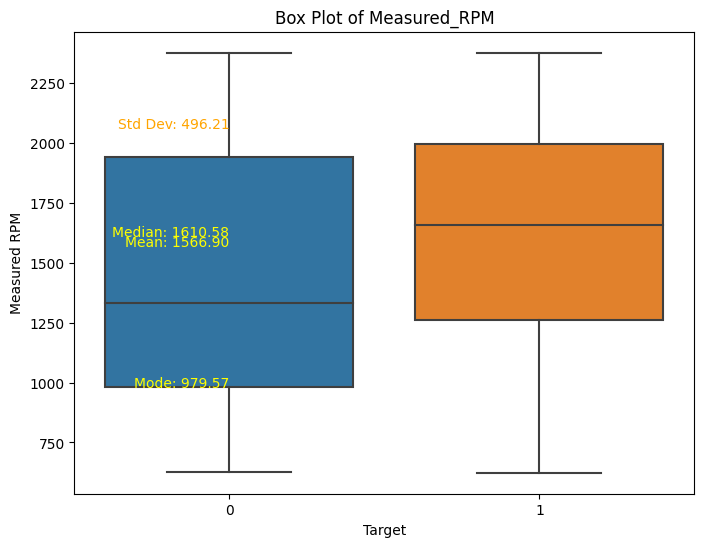

In [7]:
# Calculate mean, median, mode, and standard deviation
mean = df['Measured_RPM'].mean()
median = df['Measured_RPM'].median()
mode = df['Measured_RPM'].mode().iloc[0]  # Mode might return multiple values, so we take the first one
std_dev = df['Measured_RPM'].std()

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['target'], y=df['Measured_RPM'])
plt.title('Box Plot of Measured_RPM')
plt.xlabel('Target')
plt.ylabel('Measured RPM')

# Annotate mean, median, mode, and standard deviation
plt.text(0, mean, f'Mean: {mean:.2f}', color='yellow', fontsize=10, ha='right')
plt.text(0, median, f'Median: {median:.2f}', color='yellow', fontsize=10, ha='right')
plt.text(0, mode, f'Mode: {mode:.2f}', color='yellow', fontsize=10, ha='right')
plt.text(0, mean + std_dev, f'Std Dev: {std_dev:.2f}', color='orange', fontsize=10, ha='right')

plt.show()

### Measured RPM - Min Max

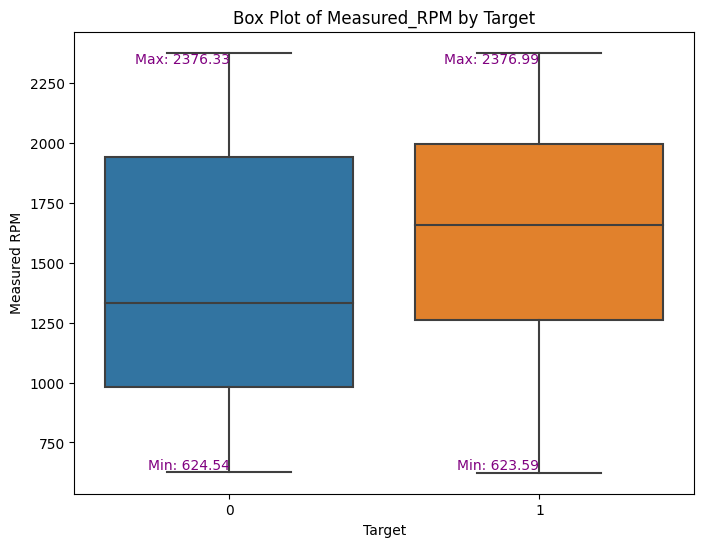

In [8]:
# Calculate minimum and maximum for each target label
min_vals = df.groupby('target')['Measured_RPM'].min()
max_vals = df.groupby('target')['Measured_RPM'].max()

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['target'], y=df['Measured_RPM'])
plt.title('Box Plot of Measured_RPM by Target')
plt.xlabel('Target')
plt.ylabel('Measured RPM')

# Annotate minimum and maximum for each target label
for target, min_val, max_val in zip(min_vals.index, min_vals, max_vals):
    plt.text(target, min_val, f'Min: {min_val:.2f}', color='purple', fontsize=10, ha='right', va='bottom')
    plt.text(target, max_val, f'Max: {max_val:.2f}', color='purple', fontsize=10, ha='right', va='top')

plt.show()

### Measured RPM - 25th & 75th Percentile

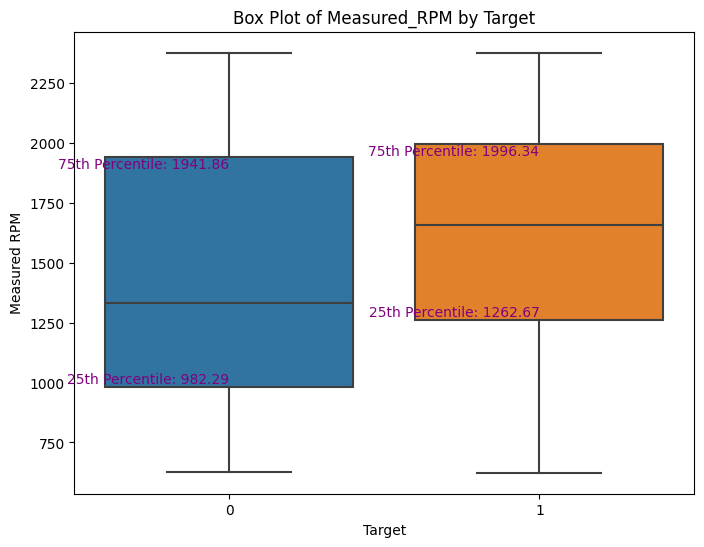

In [9]:
# Calculate percentiles for each target label
percentiles_25 = df.groupby('target')['Measured_RPM'].quantile(0.25)
percentiles_75 = df.groupby('target')['Measured_RPM'].quantile(0.75)

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['target'], y=df['Measured_RPM'])
plt.title('Box Plot of Measured_RPM by Target')
plt.xlabel('Target')
plt.ylabel('Measured RPM')

# Annotate percentiles for each target label
for target, p25, p75 in zip(percentiles_25.index, percentiles_25, percentiles_75):
    plt.text(target, p25, f'25th Percentile: {p25:.2f}', color='purple', fontsize=10, ha='right', va='bottom')
    plt.text(target, p75, f'75th Percentile: {p75:.2f}', color='purple', fontsize=10, ha='right', va='top')

plt.show()

## VOLTAGE IN

### Voltage IN - Mean, Median, Mode

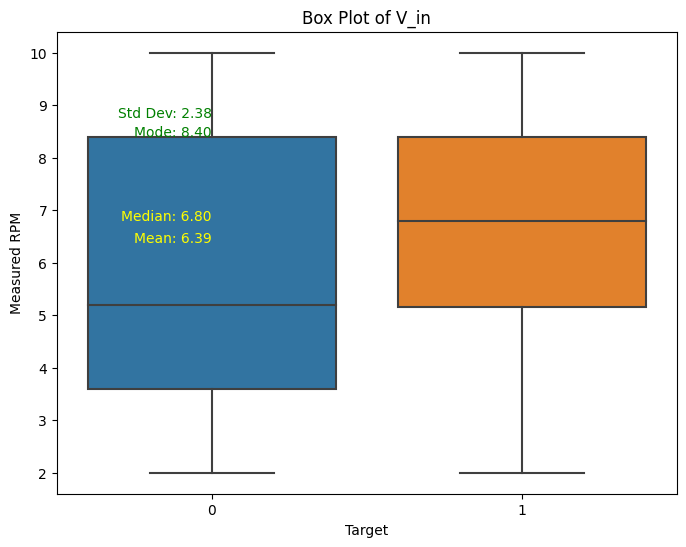

In [10]:
# Calculate mean, median, mode, and standard deviation
mean = df['V_in'].mean()
median = df['V_in'].median()
mode = df['V_in'].mode().iloc[0]  # Mode might return multiple values, so we take the first one
std_dev = df['V_in'].std()

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['target'], y=df['V_in'])
plt.title('Box Plot of V_in')
plt.xlabel('Target')
plt.ylabel('Measured RPM')

# Annotate mean, median, mode, and standard deviation
plt.text(0, mean, f'Mean: {mean:.2f}', color='yellow', fontsize=10, ha='right')
plt.text(0, median, f'Median: {median:.2f}', color='yellow', fontsize=10, ha='right')
plt.text(0, mode, f'Mode: {mode:.2f}', color='green', fontsize=10, ha='right')
plt.text(0, mean + std_dev, f'Std Dev: {std_dev:.2f}', color='green', fontsize=10, ha='right')

plt.show()

### Voltage IN - Min Max

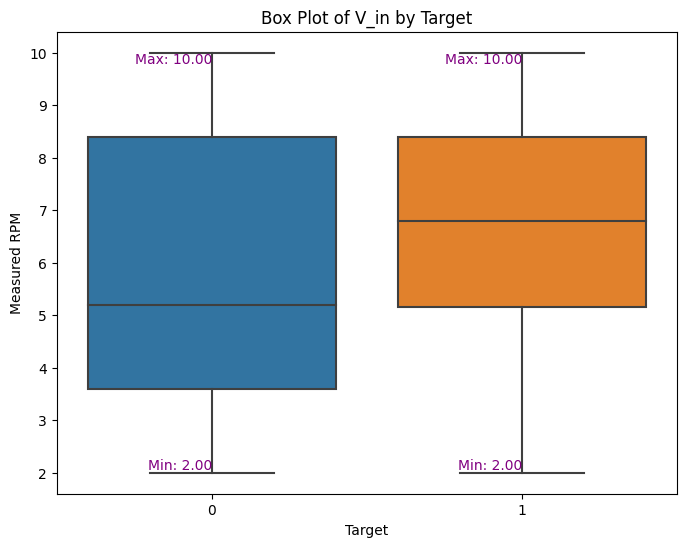

In [11]:
# Calculate minimum and maximum for each target label
min_vals = df.groupby('target')['V_in'].min()
max_vals = df.groupby('target')['V_in'].max()

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['target'], y=df['V_in'])
plt.title('Box Plot of V_in by Target')
plt.xlabel('Target')
plt.ylabel('Measured RPM')

# Annotate minimum and maximum for each target label
for target, min_val, max_val in zip(min_vals.index, min_vals, max_vals):
    plt.text(target, min_val, f'Min: {min_val:.2f}', color='purple', fontsize=10, ha='right', va='bottom')
    plt.text(target, max_val, f'Max: {max_val:.2f}', color='purple', fontsize=10, ha='right', va='top')

plt.show()

### Voltage IN - 25th & 75th Percentile

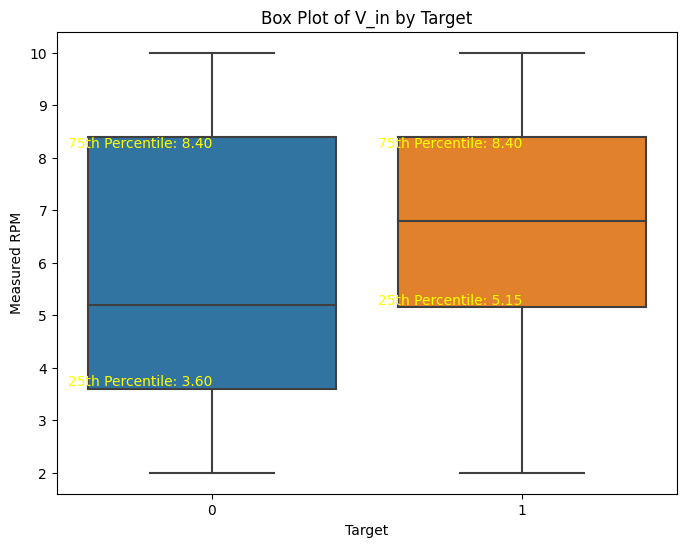

In [12]:
# Calculate percentiles for each target label
percentiles_25 = df.groupby('target')['V_in'].quantile(0.25)
percentiles_75 = df.groupby('target')['V_in'].quantile(0.75)

# Create a box plot
plt.figure(figsize=(8, 6))
sns.boxplot(x=df['target'], y=df['V_in'])
plt.title('Box Plot of V_in by Target')
plt.xlabel('Target')
plt.ylabel('Measured RPM')

# Annotate percentiles for each target label
for target, p25, p75 in zip(percentiles_25.index, percentiles_25, percentiles_75):
    plt.text(target, p25, f'25th Percentile: {p25:.2f}', color='yellow', fontsize=10, ha='right', va='bottom')
    plt.text(target, p75, f'75th Percentile: {p75:.2f}', color='yellow', fontsize=10, ha='right', va='top')

plt.show()

## TRAIN -TEST SPLIT

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop("target", axis=1),df["target"], test_size =0.1, random_state=42)

# 3.0 MODELLING

**In this chapter, we will begin by employing the RandomForestClassifier independently to classify the data. Subsequently, we will explore ensemble techniques by combining the predictions of the DecisionTreeClassifier, RandomForestClassifier, and LogisticRegression models. We will employ both voting and stacking methods to amalgamate these predictions. Following this, we will introduce the XGBoost model into our analysis. Finally, we will assess the performance of each model and ensemble technique using the F1 score and confusion matrix metrics.**

### RandomForest

In [14]:

# Initialize and train the model
model = RandomForestClassifier(n_estimators=50)
model.fit(X_train, y_train)

# Generate predictions
predictions = model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, predictions))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     26220
           1       1.00      1.00      1.00    105776

    accuracy                           1.00    131996
   macro avg       1.00      1.00      1.00    131996
weighted avg       1.00      1.00      1.00    131996



In [15]:

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, predictions))


Confusion Matrix:
[[ 25977    243]
 [    72 105704]]


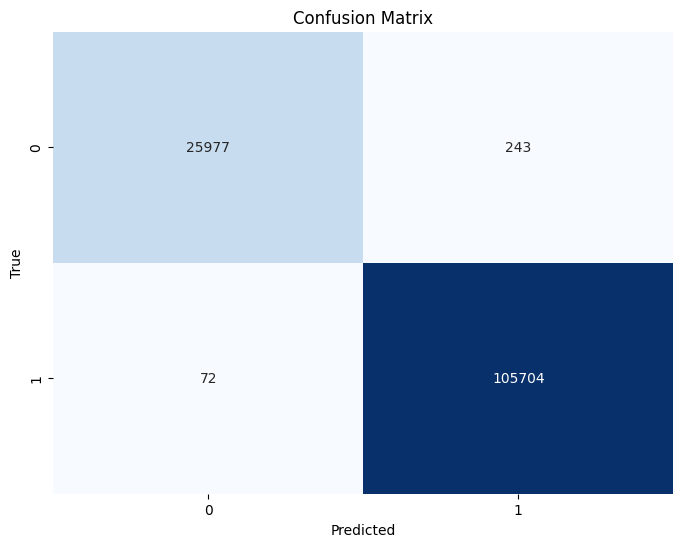

In [16]:

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


### XGBoost

In [17]:

# Initialize XGBoost classifier
xgb_model = XGBClassifier(n_estimators=50)

# Train the model
xgb_model.fit(X_train, y_train)

# Generate predictions
xgb_predictions = xgb_model.predict(X_test)

# Print classification report
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_predictions))

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95     26220
           1       0.99      0.99      0.99    105776

    accuracy                           0.98    131996
   macro avg       0.97      0.97      0.97    131996
weighted avg       0.98      0.98      0.98    131996



In [18]:
print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, xgb_predictions))


XGBoost Confusion Matrix:
[[ 24981   1239]
 [  1459 104317]]


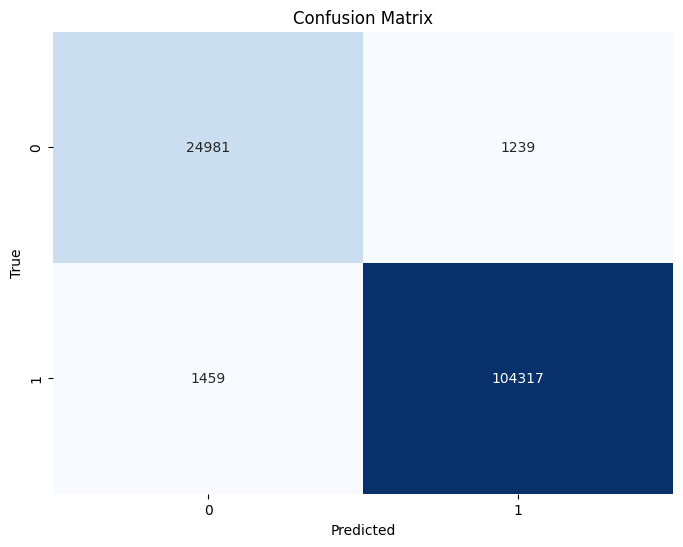

In [19]:
# Generate confusion matrix
cm = confusion_matrix(y_test, xgb_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### Stacking (BEST)

In [7]:


# Initialize base classifiers
base_classifiers = [
    ('decision_tree', DecisionTreeClassifier()),
    ('random_forest', RandomForestClassifier(n_estimators=50)),  # Random Forest instead of SVM
]

# Initialize meta classifier
meta_classifier = LogisticRegression()

# Initialize Stacking classifier
stacking_model = StackingClassifier(estimators=base_classifiers, final_estimator=meta_classifier)

# Train the model
stacking_model.fit(X_train, y_train)

# Generate predictions
stacking_predictions = stacking_model.predict(X_test)

# Print classification report
print("Stacking Classification Report:")
print(classification_report(y_test, stacking_predictions))

Stacking Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26220
           1       1.00      1.00      1.00    105776

    accuracy                           1.00    131996
   macro avg       1.00      1.00      1.00    131996
weighted avg       1.00      1.00      1.00    131996



In [21]:
# Print confusion matrix
print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, stacking_predictions))


XGBoost Confusion Matrix:
[[ 26140     80]
 [    70 105706]]


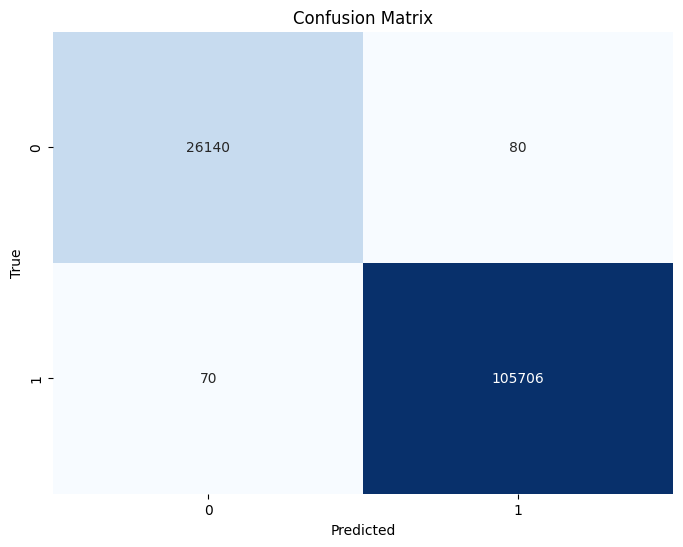

In [22]:
# Generate confusion matrix
cm = confusion_matrix(y_test, stacking_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

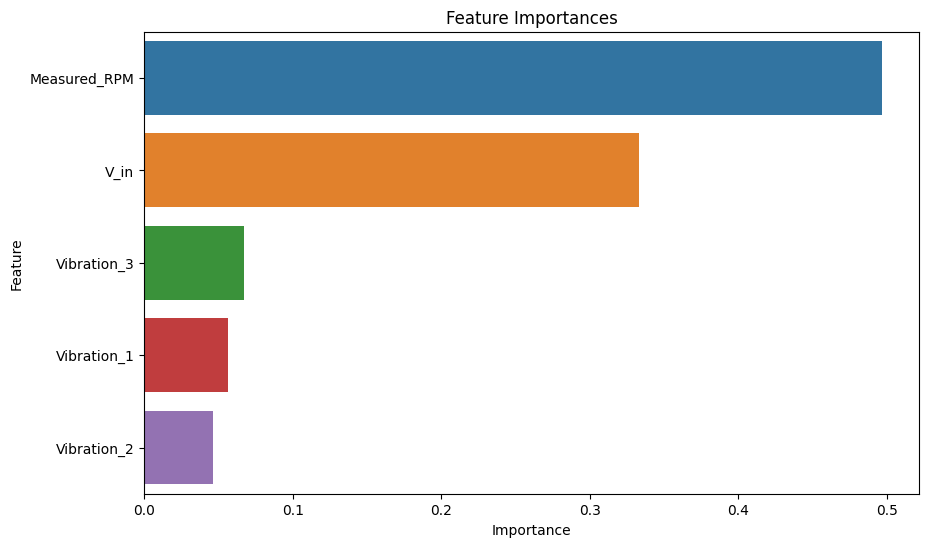

In [23]:
# Get feature importances
feature_importances = xgb_model.feature_importances_

# Get feature names
feature_names = X_train.columns

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances[indices], y=feature_names[indices])
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

### Voting

In [24]:
# Initialize individual classifiers
classifier1 = DecisionTreeClassifier()
classifier2 = RandomForestClassifier(n_estimators=100)  # Random Forest instead of SVM
classifier3 = LogisticRegression()

# Initialize Voting classifier
voting_model = VotingClassifier(estimators=[('dt', classifier1), ('rf', classifier2), ('lr', classifier3)], voting='hard')

# Train the model
voting_model.fit(X_train, y_train)

# Generate predictions
voting_predictions = voting_model.predict(X_test)

# Print classification report
print("Voting Classification Report:")
print(classification_report(y_test, voting_predictions))

Voting Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     26220
           1       1.00      1.00      1.00    105776

    accuracy                           1.00    131996
   macro avg       1.00      0.99      1.00    131996
weighted avg       1.00      1.00      1.00    131996



In [25]:
# Print confusion matrix
print("\nVoting Confusion Matrix:")
print(confusion_matrix(y_test, voting_predictions))


Voting Confusion Matrix:
[[ 25919    301]
 [    53 105723]]


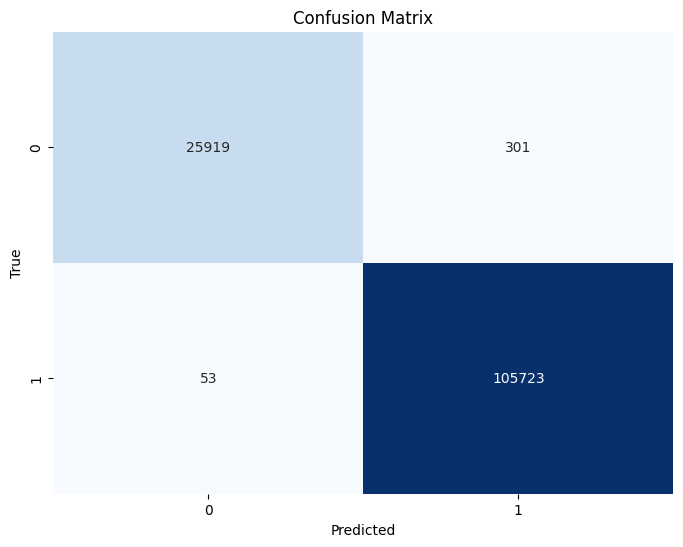

In [26]:
# Generate confusion matrix
cm = confusion_matrix(y_test, voting_predictions)
 
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# 4.0 EXPLAINABLE AI

**In this section, we are adopting the SHAP library, SHAP is a powerful technique for explaining individual predictions of machine learning models. By computing SHAP values, we can determine the importance of each feature for each prediction made by the stacking model. This helps us understand which features influence the model's decisions and to what extent**

In [ ]:
# Define a wrapper function to extract probabilities from predict_proba
def stacking_predict_proba_wrapper(model, X):
    return model.predict_proba(X)[:, 1]  # Assuming binary classification

# Wrap the stacking model's predict_proba method
stacking_wrapper_model = lambda x: stacking_predict_proba_wrapper(stacking_model, x)

# Initialize SHAP explainer for the stacking wrapper model
explainer = shap.Explainer(stacking_wrapper_model, X_train)

# Compute SHAP values
shap_values = explainer(X_test)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)
plt.show()

ExactExplainer explainer:  31%|███       | 40489/131996 [38:34<1:27:23, 17.45it/s]

In [ ]:
shap.plots.scatter((shap_values[ :, 'Measured_RPM']), color = shap_values[:,'V_in'])

In [ ]:
shap.plots.bar(shap_values)

In [8]:
with open('stacking.pkl', 'wb') as f:
    pickle.dump(stacking_model, f)

print("Model saved as 'model.pkl'")

Model saved as 'model.pkl'
